<a href="https://colab.research.google.com/github/Bo-fromLA/Bo-fromLA/blob/main/E_Commerce_analysis_ML_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-commerce (Training) DataSet = Sales Predictions using ML
---



# Objectives:

- Identify patterns and trends in most selling products.
- Develop predictive models to forecast top products that would sell most.
---
*This is a dummy dataset and we don't have much information about consumer demographics thereby we cannot analyze the consumer behavior extensively.
PLease note that some of the prices seem to be assigned randomly - hence, you might see that a food supplement might cost a few times more than a laptop, for instance.*

---

## Steps:
1. Cleaning, Preprocessing,EDA
2. Feature Engineering
3. Model Development
4. Model Evaluation and Interpretation
5. Deployment and Visualization
---
---

## 1. Cleaning, Preprocessing, EDA

In [ ]:
#importing the necessary libraries
!pip install --upgrade plotly

  Using cached plotly-5.22.0-py3-none-any.whl (16.4 MB)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

This training dataset belongs to Muhammad Roshan Riaz and can be found on his [Kaggle page here:](https://www.kaggle.com/datasets/muhammadroshaanriaz/e-commerce-trends-a-guide-to-leveraging-dataset/data)

In [ ]:
URL='/content/ecommerce_product_dataset.csv'
df = pd.read_csv(URL).set_index('ProductID')
df.head(2)

,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded
ProductID,,,,,,,,,
1,Headphones,Electronics,400.31,1.7,3772,20,0.08,466,2023-11-08
2,Headphones,Electronics,235.03,2.3,2919,663,0.33,1332,2023-09-26


In [ ]:
# getting the general summary
df.info()
df.isnull().sum()
df.shape    # Outcome: (1000, 9)
df.dtypes
df.loc[df.Sales.idxmax()] # Outcome: Screen Protector
df.ProductName.nunique()  # Outcome: 100
df.Category.value_counts()  # Outcome: Each category has 40 rows
df.Category.nunique()   # Outcome: 25
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1 to 1000
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductName    1000 non-null   object 
 1   Category       1000 non-null   object 
 2   Price          1000 non-null   float64
 3   Rating         1000 non-null   float64
 4   NumReviews     1000 non-null   int64  
 5   StockQuantity  1000 non-null   int64  
 6   Discount       1000 non-null   float64
 7   Sales          1000 non-null   int64  
 8   DateAdded      1000 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 78.1+ KB


,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded
count,1000,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000
unique,100,25,NaN,NaN,NaN,NaN,NaN,NaN,346
top,Biography,Electronics,NaN,NaN,NaN,NaN,NaN,NaN,2023-11-09
freq,22,40,NaN,NaN,NaN,NaN,NaN,NaN,7
mean,NaN,NaN,253.77551,3.025600,2498.753000,495.395000,0.251640,1011.037000,NaN
std,NaN,NaN,141.40362,1.151004,1463.241871,292.799253,0.146455,582.113466,NaN
min,NaN,NaN,10.11000,1.000000,3.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,133.09250,2.100000,1201.750000,241.750000,0.130000,502.000000,NaN
50%,NaN,NaN,251.31000,3.100000,2476.000000,505.000000,0.250000,998.000000,NaN
75%,NaN,NaN,375.82750,4.000000,3797.500000,743.500000,0.380000,1540.000000,NaN


In [ ]:
#checking general correlations
df.DateAdded=pd.to_datetime(df.DateAdded)
df = df.astype({'Sales': 'float', 'NumReviews': 'float', 'StockQuantity': 'float'})
numeric_cols=df.select_dtypes(include=['float', 'int', 'datetime'])
numeric_cols.corr()

,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded
Price,1.000000,-0.006462,0.012782,-0.006409,-0.045133,0.029076,-0.014226
Rating,-0.006462,1.000000,-0.009832,0.000576,0.024495,0.008475,0.012658
NumReviews,0.012782,-0.009832,1.000000,-0.020958,-0.015579,0.056586,0.025629
StockQuantity,-0.006409,0.000576,-0.020958,1.000000,-0.007659,-0.001458,0.014946
Discount,-0.045133,0.024495,-0.015579,-0.007659,1.000000,0.027413,0.035258
Sales,0.029076,0.008475,0.056586,-0.001458,0.027413,1.000000,0.002197
DateAdded,-0.014226,0.012658,0.025629,0.014946,0.035258,0.002197,1.000000


The preliminary correlation matrix above shows us that we don't have very strong corrleations to find the features most affecing the sales. The closest ones are Price, Number of reviews and Discounts. Surprisingly, the Rating feature has a very low correlation to sales. Perhaps going further we can add some dummy variables and split some columns to dig deeper into the dataset.

In [ ]:
# Analyzing the distribution of sales within each category to choose top 5 categories and later top 20 products or so for visualization
sales_distribution = df.groupby('Category')['Sales'].describe().sort_values(by='max', ascending=False)
sales_distribution.head(5)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Mobile phone accessories,40.0,1091.500,611.045090,35.0,566.25,1124.0,1598.50,1997.0
Art and crafting materials,40.0,1147.800,670.188653,0.0,518.00,1377.5,1749.75,1995.0
Bedsheets,40.0,1165.775,616.037981,55.0,696.75,1165.5,1764.00,1991.0
Bath and body,40.0,1061.350,581.352647,110.0,610.00,1005.5,1592.00,1983.0
Skin care,40.0,1022.225,518.534250,1.0,662.50,1020.0,1402.75,1981.0


In [ ]:
# First, let's add categorical values to arbitrarily split price into tiers
df['PriceTiers'] = pd.cut(df['Price'], bins=[0,50,100,250,370,float('inf')], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
df.head(2)

,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,PriceTiers
ProductID,,,,,,,,,,
1,Headphones,Electronics,400.31,1.7,3772.0,20.0,0.08,466.0,2023-11-08,Very High
2,Headphones,Electronics,235.03,2.3,2919.0,663.0,0.33,1332.0,2023-09-26,Medium


In [ ]:
# Let's create interactive charts with Plotly to get the general overview of the dataset.

# top5_categories = df.groupby('Category')['Sales'].sum().sort_values(ascending=False).head(5).index
# top5_df = df[df['Category'].isin(top5_categories)]

top20_products = df.groupby('ProductName')['Sales'].sum().sort_values(ascending=False).head(20)
top20_products_df = df[df['ProductName'].isin(top20_products.index)].groupby(['ProductName', 'Category'], as_index=False).agg({'Sales': 'sum', 'Price': 'mean'})

category_sales = df.groupby('Category')['Sales'].sum()
category_sales_percentage = category_sales / category_sales.sum() * 100

# Using plotly interactive visualization for easy access to information
# You can drag and select a portion of a plot and it will zoom in (*double-click to zoom out)
# You can hover and move your mouse over any plot and the values will popup

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Category Distribution by Sales",
                    "Top 20 Products by Sales",
                    "Sales Distribution by Price Tiers",
                    "Correlation Heatmap"),
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "box"}, {"type": "heatmap"}]],
    vertical_spacing=0.2
)

# The pie plot (you can unmark some categories in the legend to see the redistribution)
fig.add_trace(go.Pie(values=category_sales_percentage,
                     labels=category_sales_percentage.index,
                     marker=dict(colors=category_sales_percentage.index),
                     showlegend=False),     # Change to True and uncomment the section below to toggle with the pie chart distribution
              row=1, col=1)
# fig.update_layout(legend = dict(orientation="v", yanchor="top",
#                                 y=1, xanchor="left", x=0,
#                                 font=dict(size=9),
#                                 bgcolor='rgba(0, 0, 0, 0)',
#                                 traceorder='normal',
#                                 title = "Sales by category"))

# The Bar plot
fig.add_trace(go.Bar(y=top20_products.values,
x=top20_products.index,
                     name='Top 20 Products by Sales',
                     marker=dict(color = top20_products),
                     showlegend=False),
              row=1, col=2)

# The box plot
price_tiers_order = ["Very Low", "Low", "Medium", "High", "Very High"]
box_fig = px.box(df, x='PriceTiers', y='Sales', category_orders={'PriceTiers': price_tiers_order}, color='PriceTiers')
for trace in box_fig['data']:
    trace.update(showlegend=False)
    fig.add_trace(trace, row=2, col=1)
fig.update_xaxes(categoryorder='array', categoryarray=price_tiers_order, row=2, col=1)

# The heat map
numeric_cols = df.select_dtypes(include=['float64', 'int64'])
correlation = numeric_cols.corr()
fig.add_trace(go.Heatmap(z=correlation.values,
                         x=correlation.columns,
                         y=correlation.index,
                         colorscale='Viridis',
                         colorbar=dict(len=0.43, y=0.41, yanchor='top')),
              row=2, col=2)

fig.update_layout(height=800, autosize=True, showlegend=True,
                  title_text="Exploratory Sales Analysis Overview", title_x=0.5, title_y=0.97, title_font_size=24)

fig.show()

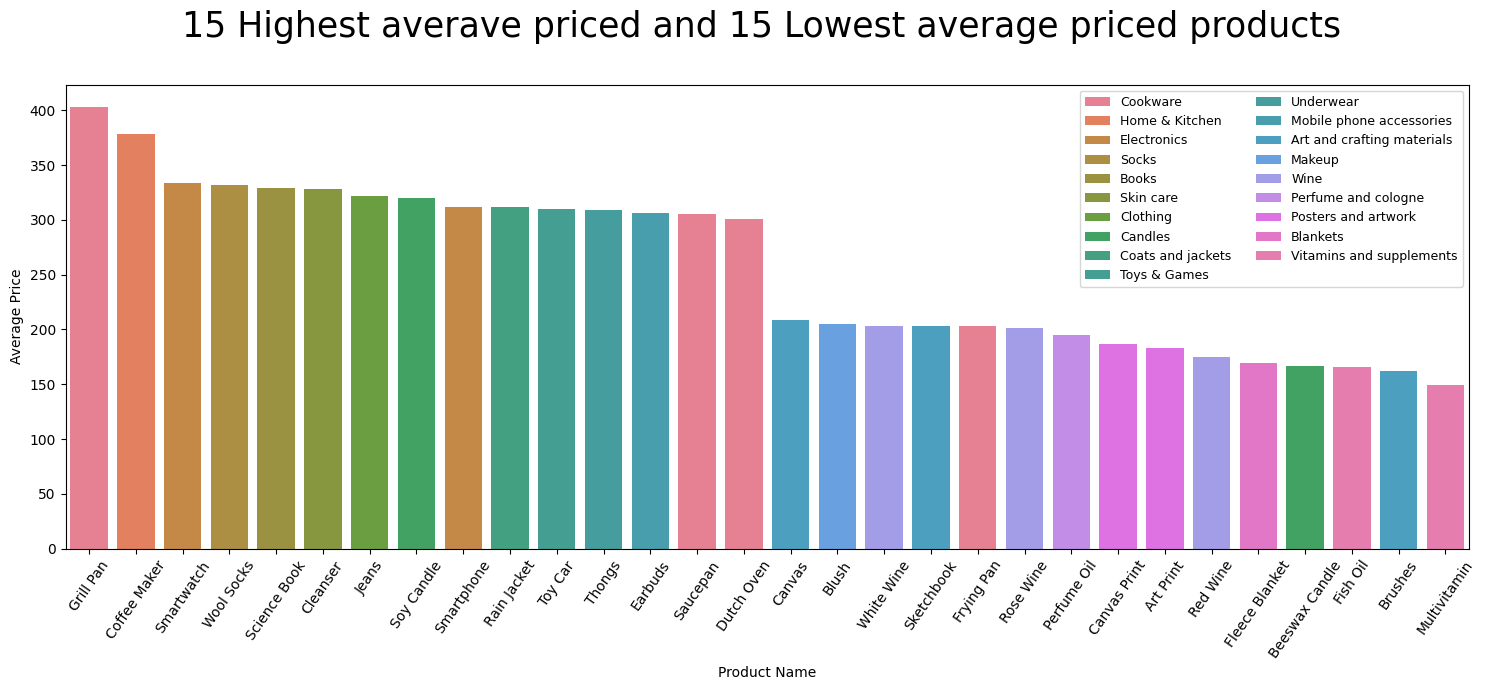

In [ ]:
sorted_mean=df.groupby(['ProductName', 'Category'])['Price'].mean().sort_values(ascending=False).reset_index()
sorted = pd.concat([sorted_mean.head(15),sorted_mean.tail(15)])
plt.figure(figsize=(15,7))
ax = sns.barplot(x='ProductName', y='Price', hue='Category', data=sorted)
plt.xticks(rotation=55)
plt.xlabel('Product Name')
plt.ylabel('Average Price')
plt.title('15 Highest averave priced and 15 Lowest average priced products \n', fontsize=25)
plt.legend(loc='upper right', fontsize=9, ncol=2)

plt.tight_layout()
plt.show()

from the charts above we can see that the categories, sales by price tiers, and even the mean of the prices are relatively evenly distributed amoongst the values. Let us see if creating dummy variable will enhace and aid at finding more noticeable differences and stronger correlations.

---
---

## 2. Feature Engineering and Model Development
- Creating new features that may enhance predictive models.

In [ ]:
# Since we have many repeating products at different prices I will use the price as an indication of differnt Brand products
# this way, instead of grouping the data frame by products, I can keep each product as a separate entity when trying to predict their sales

df1=df.copy()
df1['ProductName'] = df['ProductName'] + ' ($' + df['Price'].astype(str) + ')'

# breaking apart the 'DateAdded' in case there is an unusual correlation
df1['DateAdded'] = pd.to_datetime(df1['DateAdded'])
df1['YearAdded'] = df1['DateAdded'].dt.year.astype(float)
df1['MonthAdded'] = df1['DateAdded'].dt.month.astype(float)

df1.head(2)

,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,PriceTiers,YearAdded,MonthAdded
ProductID,,,,,,,,,,,,
1,Headphones ($400.31),Electronics,400.31,1.7,3772.0,20.0,0.08,466.0,2023-11-08,Very High,2023.0,11.0
2,Headphones ($235.03),Electronics,235.03,2.3,2919.0,663.0,0.33,1332.0,2023-09-26,Medium,2023.0,9.0


In [ ]:
# Getting dummy variables for the 'object' type features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1['PriceTiers_encoded'] = le.fit_transform(df1['PriceTiers' ])
df1['Category_encoded'] = le.fit_transform(df1['Category'])
df1['Category'] = df1['Category'] + ' (' + df1['Category_encoded'].astype(str) + ')'
df1.head(2)

,ProductName,Category,Price,Rating,NumReviews,StockQuantity,Discount,Sales,DateAdded,PriceTiers,YearAdded,MonthAdded,PriceTiers_encoded,Category_encoded
ProductID,,,,,,,,,,,,,,
1,Headphones ($400.31),Electronics (11),400.31,1.7,3772.0,20.0,0.08,466.0,2023-11-08,Very High,2023.0,11.0,3,11
2,Headphones ($235.03),Electronics (11),235.03,2.3,2919.0,663.0,0.33,1332.0,2023-09-26,Medium,2023.0,9.0,2,11


In [ ]:
#final check before selecting features

matrix=df1[['Price', 'Rating', 'NumReviews', 'Discount', 'Sales', 'StockQuantity', 'DateAdded', 'YearAdded', 'MonthAdded', 'PriceTiers_encoded', 'Category_encoded']].corr()
matrix

,Price,Rating,NumReviews,Discount,Sales,StockQuantity,DateAdded,YearAdded,MonthAdded,PriceTiers_encoded,Category_encoded
Price,1.000000,-0.006462,0.012782,-0.045133,0.029076,-0.006409,-0.014226,-0.031684,0.040356,0.022086,-0.002221
Rating,-0.006462,1.000000,-0.009832,0.024495,0.008475,0.000576,0.012658,-0.014559,0.036335,-0.005502,0.021444
NumReviews,0.012782,-0.009832,1.000000,-0.015579,0.056586,-0.020958,0.025629,-0.008840,0.042941,0.031789,0.017067
Discount,-0.045133,0.024495,-0.015579,1.000000,0.027413,-0.007659,0.035258,0.054075,-0.060944,0.009549,0.048069
Sales,0.029076,0.008475,0.056586,0.027413,1.000000,-0.001458,0.002197,0.015661,-0.021670,-0.052517,-0.038279
StockQuantity,-0.006409,0.000576,-0.020958,-0.007659,-0.001458,1.000000,0.014946,-0.013616,0.037641,-0.012142,0.010488
DateAdded,-0.014226,0.012658,0.025629,0.035258,0.002197,0.014946,1.000000,0.863389,-0.482441,-0.062903,0.007046
YearAdded,-0.031684,-0.014559,-0.008840,0.054075,0.015661,-0.013616,0.863389,1.000000,-0.856347,-0.045288,-0.015709
MonthAdded,0.040356,0.036335,0.042941,-0.060944,-0.021670,0.037641,-0.482441,-0.856347,1.000000,0.012574,0.030443
PriceTiers_encoded,0.022086,-0.005502,0.031789,0.009549,-0.052517,-0.012142,-0.062903,-0.045288,0.012574,1.000000,0.030205


*Since there are no strong correlations, we can experiment and create different groups of single and bunched features as independent variables to parse their results.*

---

### 3.1. Linear regression

---
We start with individual features to store their coefficients in mind when comparing with more complex models. We will check MunReviews, Price, and Discount separately against the Sales.

In [ ]:
# a quick SLR check for Price and Number of Reviews (just to isolate them separately)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#=====================================================#
# For NumReviews feature
#=====================================================#
Xr = df1[['NumReviews']]
yr = df1['Sales']

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=0.2, random_state=11)

lr_r= LinearRegression()
lr_r.fit(Xr_train, yr_train)
yr_hat = lr_r.predict(Xr_test)

#print(Xr_train.shape, yr_train.shape)   #Output: (800, 1) (800,)
print('MSE for Number of Reviews:', mean_squared_error(yr_test, yr_hat))   #Output: 354066.6317460998
print('R^2 score for Number of Reviews:', lr_r.score(Xr_test, yr_test))    #Output: -0.005827338352040856
print()

#=====================================================#
# For Price feature
#=====================================================#
Xp = df1[['Price']]
yp = df1['Sales']

Xp_train, Xp_test, yp_train, yp_test = train_test_split(Xp, yp, test_size=0.2, random_state=11)

lr_p= LinearRegression()
lr_p.fit(Xp_train, yp_train)
yp_hat = lr_p.predict(Xp_test)

#print(Xp_train.shape, yp_train.shape)   #Output: (800, 1) (800,)
print('MSE for Price:', mean_squared_error(yp_test, yp_hat))   #Output: 303050.94851367245
print('R^2 score for Price:', lr_p.score(Xp_test, yp_test))    #Output: 0.0024400988873987117
print()

#=====================================================#
# For the Discount feature
#=====================================================#
Xd = df1[['Discount']]
yd = df1['Sales']

Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=0.2, random_state=11)

lr_d= LinearRegression()
lr_d.fit(Xd_train, yd_train)
yd_hat = lr_d.predict(Xd_test)

#print(Xd_train.shape, yd_train.shape)   #Output: (800, 1) (800,)
print('MSE for Discount:', mean_squared_error(yd_test, yd_hat))   #Output: 346680.84470349154
print('R^2 score for Discount:', lr_d.score(Xd_test, yd_test))    #Output: -0.0018723729734910766

MSE for Number of Reviews: 347268.18891630246
R^2 score for Number of Reviews: -0.037112673241397554

MSE for Price: 335505.63368590624
R^2 score for Price: -0.0019839298421970852

MSE for Discount: 337729.5753652443
R^2 score for Discount: -0.008625707505129476


---
Our coefficients of determinations, especially representing the Discount


### LR for the grouped Categry df

In [ ]:
# Here I grouped the df by Categories and tried a Simple linear regression to test the model.
from sklearn.preprocessing import StandardScaler

category_sales = df1.groupby('Category').agg({
    'Sales': 'sum',
    'Price': 'mean',
    'NumReviews': 'sum' ,
    'Discount': 'mean'
}).reset_index()
category_sales.head(2)

Xc = category_sales[['Discount']]
yc = category_sales['Sales']

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

le = LinearRegression()
le.fit(X_train_scaled, y_train)
y_pred = le.predict(X_test_scaled)


print("MSE by category:", mean_squared_error(y_test, y_pred))     # Outcome: 24696002.33621116
print("R^2 score by category:", r2_score(y_test, y_pred))         # Outcome:  -0.9782509889436575

MSE by category: 24696002.33621116
R^2 score by category: -0.9782509889436575


---
Grouping the table by categories see to work way worse in the Linear model. Going further we will stick to evaluating the table as is with different feature sets and models.

### MLR with all products

**We can run our models on 2 different types of features:**
- higher correlation features (given the overall low correlation in the df)
- and based on the correlation of the original set of df features

In [ ]:
# As an option for larger correlation matrices:
#------------------------------------
# sales_corr = matrix['Sales'].abs()
# threshold = 0.03
# high_corr_features = sales_corr[sales_corr > threshold].index.tolist()

# removing 'Sales' from the list of features (since it's the target variable)
# high_corr_features.remove('Sales')

# print("Selected features based on te set threshold:", high_corr_features)
      # Outcome: Selected features based on correlation threshold: ['NumReviews', 'PriceTiers_encoded', 'Category_encoded']

In [ ]:
# 1) higher correlated (both positive and negative) with newly generated dummy features: h_features

h_features = ['NumReviews', 'Price', 'Discount', 'PriceTiers_encoded', 'Category_encoded']
X5 = df1[h_features]
Y5 = df1['Sales']

# 2) with 3 original features: o_features

o_features = ['NumReviews', 'Price', 'Discount']
X3 = df1[o_features]
Y3 = df1['Sales']

print('X5-shape: ', X5.shape, 'Y5-shape: ', Y5.shape)
print('X3-shape: ', X3.shape, 'Y3-shape: ', Y3.shape)

X5-shape:  (1000, 5) Y5-shape:  (1000,)
X3-shape:  (1000, 3) Y3-shape:  (1000,)


In [ ]:
# using train_test_split to start testing a few models
# creating scaled input data for comparison

from sklearn.model_selection import train_test_split

X5_train, X5_test, Y5_train, Y5_test = train_test_split(X5, Y5, test_size=0.2, random_state=11)
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size=0.2, random_state=11)

scaler5 = StandardScaler()
X5s_train = scaler5.fit_transform(X5_train)
X5s_test = scaler5.transform(X5_test)

scaler3 = StandardScaler()
X3s_train = scaler3.fit_transform(X3_train)
X3s_test = scaler3.transform(X3_test)

In [ ]:
# still continuing with the Linear Regressioon first

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 5 features
lr_5= LinearRegression()
lr_5.fit(X5_train, Y5_train)
y5_pred = lr_5.predict(X5_test)

print('MSE for Linear Model with 5 features:', mean_squared_error(Y5_test, y5_pred))   #Output: 103345.9233079976
print('R^2 score for Linear Model with 5 features:', lr_5.score(X5_test, Y5_test))    #Output:  -0.03064911751624444
print()

# 5 scaled features
lr_5s= LinearRegression()
lr_5s.fit(X5s_train, Y5_train)
y5s_pred = lr_5s.predict(X5s_test)

print('MSE for Linear Model with 5 scaled features:', mean_squared_error(Y5_test, y5s_pred))   #Output: 345103.92330799776
print('R^2 score for Linear Model with 5 scaled features:', lr_5s.score(X5s_test, Y5_test))    #Output: -0.030649117516244884
print()

# 3 features
lr_3= LinearRegression()
lr_3.fit(X3_train, Y3_train)
y3_pred = lr_3.predict(X3_test)

print(f'Mean squared error for Linear Model with 3 features: {mean_squared_error(Y5_test, y3_pred)}')   #Output:47613.36500433803
print(f'R^2 score for Linear Model with 3 features: {lr_3.score(X3_test, Y3_test)}')   #Output: -0.03814353787808855
print()

# 3 scaled features
lr_3s= LinearRegression()
lr_3s.fit(X3s_train, Y3_train)
y3s_pred = lr_3s.predict(X3s_test)

print(f'Mean squared error for Linear Model with 3 scaled features: {mean_squared_error(Y3_test, y3s_pred)}')   #Output: 347613.36500433774
print(f'R^2 score for Linear Model with 3 scaled features: {lr_3s.score(X3s_test, Y3_test)}')   #Output: -0.03814353787808766



MSE for Linear Model with 5 features: 345103.9233079976
R^2 score for Linear Model with 5 features: -0.03064911751624444

MSE for Linear Model with 5 scaled features: 345103.92330799776
R^2 score for Linear Model with 5 scaled features: -0.030649117516244884

Mean squared error for Linear Model with 3 features: 347613.36500433803
R^2 score for Linear Model with 3 features: -0.03814353787808855

Mean squared error for Linear Model with 3 scaled features: 347613.36500433774
R^2 score for Linear Model with 3 scaled features: -0.03814353787808766


*we can see above that our MSE dropped significantly (beforee scaling), but the R squared is stil in the negative making the linear model not very suitable for prediction. Let's take a look at the model utilizing the fitted line in a plot:*

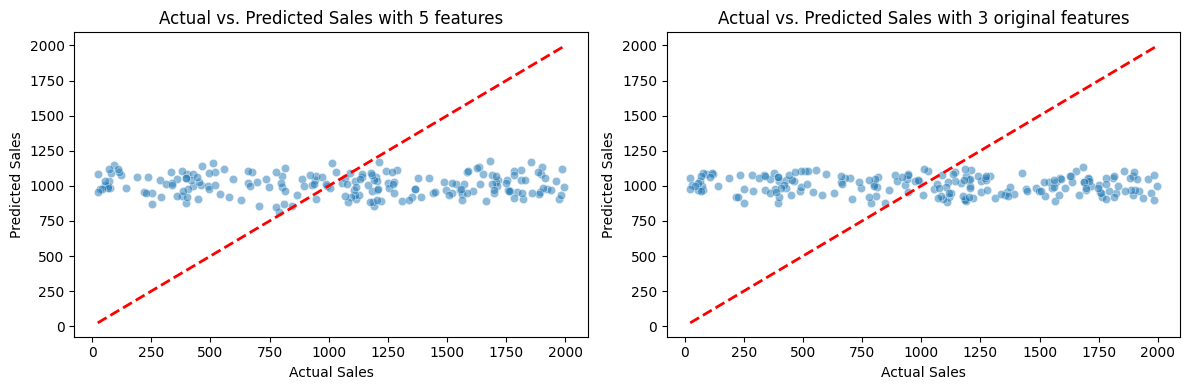

In [ ]:
plt.figure(figsize=(12, 4))

# Plot for 5 features
plt.subplot(1, 2, 1)
ax = sns.scatterplot(x=Y5_test, y=y5_pred, alpha=0.5)
ax.plot([Y5_test.min(), Y5_test.max()], [Y5_test.min(), Y5_test.max()], '--r', linewidth=2)
ax.set_title('Actual vs. Predicted Sales with 5 features')
ax.set_xlabel('Actual Sales')
ax.set_ylabel('Predicted Sales')

# Plot for 3 original features
plt.subplot(1, 2, 2)
ax1 = sns.scatterplot(x=Y3_test, y=y3_pred, alpha=0.5)
ax1.plot([Y3_test.min(), Y3_test.max()], [Y3_test.min(), Y3_test.max()], '--r', linewidth=2)
ax1.set_title('Actual vs. Predicted Sales with 3 original features')
ax1.set_xlabel('Actual Sales')
ax1.set_ylabel('Predicted Sales')

plt.tight_layout()
plt.show()

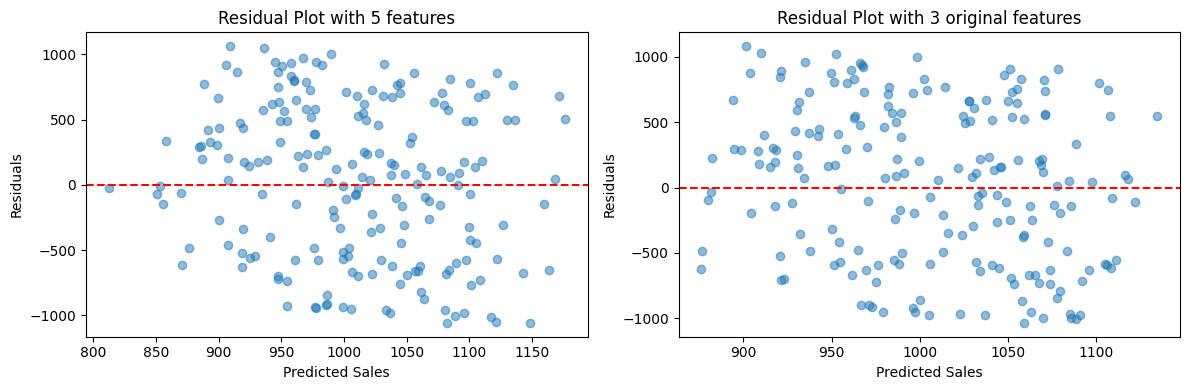

In [ ]:
#residual plot to visualize the outcome
residuals_5 = Y5_test - y5_pred
residuals_3 = Y3_test - y3_pred
plt.figure(figsize=(12, 4))

# Residual plot for 5 features
plt.subplot(1, 2, 1)
plt.scatter(y5_pred, residuals_5, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot with 5 features')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')

# Residual plot for original features
plt.subplot(1, 2, 2)
plt.scatter(y3_pred, residuals_3, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot with 3 original features')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


overall the 5 feature set seems to perform slightly better judging by the LR

---
### 3.2. Polynomial degree, GridSearchCV and Pipeline with Linear Regression


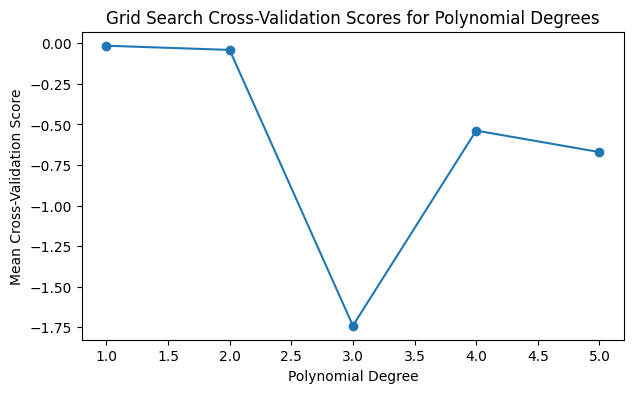

Best parameters: {'polynomialfeatures__degree': 1}
Best score: -0.015205689768055364
MSE for 5 feature Polynomial:  345103.92330799776
R^2 for 5 feature Polynomial:  -0.030649117516244884
{'polynomialfeatures__degree': 1}
-340325.01532047143
MSE for 5 feature scaled Polynomial: 384791.33929670486
R^2 for 5 feature scaled Polynomial: -0.1491751541755133


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but PolynomialFeatures was fitted with feature names



In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Working with 5 features

lr= LinearRegression()
poly = PolynomialFeatures()
pipe5 = make_pipeline(poly, lr)

param_grid = {'polynomialfeatures__degree': [1, 2, 3, 4, 5]}
grid = GridSearchCV(pipe5, param_grid, cv=5)
grid.fit(X5_train, Y5_train)
y5_pred_poly = grid.predict(X5_test)

mean_test_scores = grid.cv_results_['mean_test_score']
degrees = param_grid['polynomialfeatures__degree']

# Plot for the cross-validation scores
plt.figure(figsize=(7, 4))
plt.plot(degrees, mean_test_scores, marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Grid Search Cross-Validation Scores for Polynomial Degrees')
plt.show()

print("Best parameters:", grid.best_params_)    # Outcome: Best parameters: {'polynomialfeatures__degree': 1}
print("Best score:", grid.best_score_)        # Outcome: Best score: -0.22262450020328658

pr5_best_model = grid.best_estimator_
pr5_best_model.fit(X5_train, Y5_train)
pr5_yhat= pr5_best_model.predict(X5_test)
print('MSE for 5 feature Polynomial: ', mean_squared_error(Y5_test, pr5_yhat))     #Output: 345103.92330799776
print('R^2 for 5 feature Polynomial: ', r2_score(Y5_test, pr5_yhat))     #Output: -0.030649117516244884



grid_s5= GridSearchCV(pipe5, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_s5.fit(X5s_train, Y5_train)
pr5s_yhat = grid.predict(X5s_test)

print(grid_s5.best_params_)     #Output: {'polynomialfeatures__degree': 1}
print(grid_s5.best_score_)      #Output: -340325.01532047143
degrees_5s = param_grid['polynomialfeatures__degree']
pr_5s_best_model = grid_s5.best_estimator_
pr_5s_best_model.fit(X5s_train, Y5_train)
pr_5s_yhat= pr_5s_best_model.predict(X5s_test)
print(f'MSE for 5 feature scaled Polynomial: {mean_squared_error(Y5_test, pr5s_yhat)}')     #Output: 384791.33929670486
print(f'R^2 for 5 feature scaled Polynomial: {r2_score(Y5_test, pr5s_yhat)}')              #Output: -0.1491751541755133


*We can see see that there is no better polinomial degree, bringing us back to the simple linear regression. However, we will keep looking for another Regression Models in search for the better performing one.*



In [ ]:
# Working with original features

lr= LinearRegression()
poly = PolynomialFeatures()
pipe3 = make_pipeline(poly, lr)

param_grid_o = {'polynomialfeatures__degree': [1, 2, 3, 4, 5]}  # Original features
grid_3 = GridSearchCV(pipe3, param_grid_o, cv=5)
grid_3.fit(X3_train, Y3_train)
y3_pred_poly = grid_3.predict(X3_test)

print("Best parameters:", grid_3.best_params_)    # Outcome: Best parameters: {'polynomialfeatures__degree': 1}
print("Best score:", grid_3.best_score_)        # Outcome: Best score: -0.012661315925976835

pr3_best_model = grid_3.best_estimator_
pr3_best_model.fit(X3_train, Y3_train)
pr3_yhat= pr3_best_model.predict(X3_test)

print('MSE for 3 feature Polynomial: ', mean_squared_error(Y3_test, pr3_yhat))     #Output: 347613.36500433774
print('R^2 for 3 feature Polynomial: ', r2_score(Y3_test, pr3_yhat))     #Output: -0.03814353787808766

Best parameters: {'polynomialfeatures__degree': 1}
Best score: -0.012661315925976835
MSE for 3 feature Polynomial:  347613.36500433774
R^2 for 3 feature Polynomial:  -0.03814353787808766


**Conclusion:** so far The Polinomial features seem unnecessary with the repeating degree 1 for both 5 and 3 feature sets.


---
### 3.3. Decision Tree




In [ ]:
# Tree for the 5-feature X:

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
params = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

grid_tree = GridSearchCV(tree, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_tree.fit(X5_train,Y5_train)

# Best parameters and score
best_params = grid_tree.best_params_
best_score = -grid_tree.best_score_

print(f'Best parameters: {best_params}')    # Output: Best parameters: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 20}
print(f'Best MSE: {best_score}')          # Output: Best MSE: 412831.573385646


# Now we can try running the best parameters:

best_tree = grid_tree.best_estimator_
yhat = best_tree.predict(X5_test)

print('R^2 for the Tree with 5 features is: ', best_tree.score(X5_test, Y5_test))     #Output: -0.-0.337920277474294
print('MSE for the Tree with 5 features is: ', mean_squared_error(Y5_test, yhat))      #Output: 447991.00778585416


Best parameters: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 20}
Best MSE: 412831.573385646
R^2 for the Tree with 5 features is:  -0.337920277474294
MSE for the Tree with 5 features is:  447991.00778585416


In [ ]:

# We can repeat the whole Regression Tree for the original 3 features as follows:

tree_3 = DecisionTreeRegressor()
params_3 = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8]
}

grid_tree_3 = GridSearchCV(tree_3, params_3, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_tree_3.fit(X3_train, Y3_train)

# Best parameters and score
best_params_3 = grid_tree_3.best_params_
best_score_3 = -grid_tree_3.best_score_

print(f'Best parameters: {best_params_3}')    # Output: Best parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20}
print(f'Best MSE: {best_score_3}')          # Output: Best MSE: 418962.1880462784

best_tree_3= grid_tree_3.best_estimator_
y3_hat = best_tree_3.predict(X3_test)

print(f'R^2 for the Tree with 3 features is: {best_tree_3.score(X3_test, Y3_test)}')     #Output: -0.3481675106696205
print(f'MSE for the Tree with 3 features is: {mean_squared_error(Y3_test, y3_hat)}')      #Output: MSE for the Tree with 3 features is: 451422.20499803574

Best parameters: {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 20}
Best MSE: 418962.1880462784
R^2 for the Tree with 3 features is: -0.3481675106696205
MSE for the Tree with 3 features is: 451422.20499803574


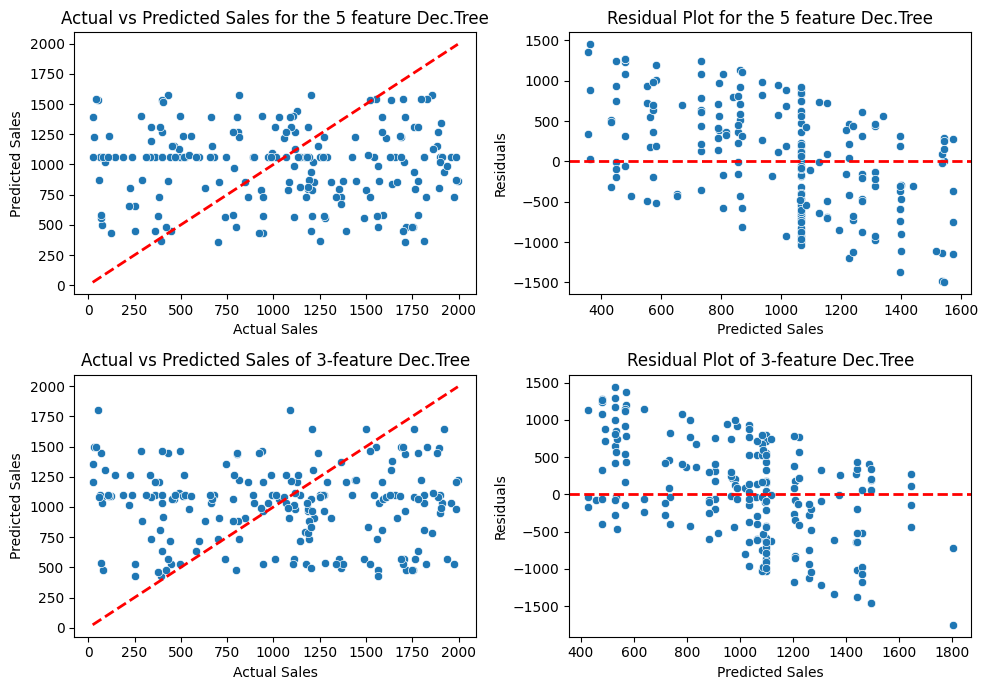

In [ ]:
# Plots for the Decicion Tree for the 5 features
plt.figure(figsize=(10, 7))
residuals_t5 = Y5_test - yhat

# Plot 1: Actual vs Predicted Sales
plt.subplot(2, 2, 1)
sns.scatterplot(x=Y5_test, y=yhat)
plt.plot([Y5_test.min(), Y5_test.max()], [Y5_test.min(), Y5_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales for the 5 feature Dec.Tree')

# Plot 2: Residual Plot
plt.subplot(2, 2, 2)
sns.scatterplot(x=yhat, y=residuals_t5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot for the 5 feature Dec.Tree')

residuals_t3 = Y3_test - y3_hat

# Plot 3: Actual vs Predicted Sales
plt.subplot(2, 2, 3)
sns.scatterplot(x=Y3_test, y=y3_hat)
plt.plot([Y3_test.min(), Y3_test.max()], [Y3_test.min(), Y3_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales of 3-feature Dec.Tree')

# Plot 2: Residual Plot
plt.subplot(2, 2, 4)
sns.scatterplot(x=y3_hat, y=residuals_t3)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot of 3-feature Dec.Tree')

plt.tight_layout()
plt.show()


---
### 3.4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import time
# We test the 5-feature set first

param_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf5 = RandomForestRegressor(random_state=11)
grid_rf5 = GridSearchCV(rf5, param_grid=param_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

strt_time = time.time()
grid_rf5.fit(X5_train, Y5_train)
end_time = time.time()
print(f'Runtime for Random Forest fitting: {(end_time - strt_time)/60} minutes').   # Output: 9.868215517203014 minutes

best_params_rf5 = grid_rf5.best_params_
best_score_rf5 = -grid_rf5.best_score_

print("Best parameters: ", best_params_rf5)    # Output: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
print('Best score: ', best_score_rf5)          # Output: Best score:  344728.84160681686

best_model_rf5= grid_rf5.best_estimator_
yhat_rf5 = best_model_rf5.predict(X5_test)

mse_rf5 = mean_squared_error(Y5_test, yhat_rf5)
r2_rf5 = r2_score(Y5_test, yhat_rf5)

print(f'Mean Squared Error for Random Forest: {mse_rf5}')      # Output: Mean Squared Error for Random Forest: 362287.60787860455
print(f'R² Score for Random Forest: {r2_rf5}')               # R² Score for Random Forest: -0.08196800479115818

Runtime for Random Forest fitting: 9.868215517203014 minutes
Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best score:  344728.84160681686
Mean Squared Error for Random Forest: 362287.60787860455
R² Score for Random Forest: -0.08196800479115818


In [ ]:
# Time to test the 3-feature set
import time
rf3 = RandomForestRegressor(random_state=11)
param_rf3 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search_rf3 = GridSearchCV(rf3, param_grid=param_rf3, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

start_time = time.time()
grid_search_rf3.fit(X3_train, Y3_train)
end_time = time.time()
print(f'Runtime for Random Forest fitting: {(end_time - start_time)/60:.2f} minutes')   # Outcome: 10.30 minutes

best_params_rf3 = grid_search_rf3.best_params_
best_score_rf3 = -grid_search_rf3.best_score_

print("Best parameters: ", best_params_rf3)    # Output: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
print('Best score: ', best_score_rf3)          # Output: 341558.56060275354

best_model_rf3= grid_search_rf3.best_estimator_
yhat_rf3 = best_model_rf3.predict(X3_test)

mse_rf3 = mean_squared_error(Y3_test, yhat_rf3)
r2_rf3 = r2_score(Y3_test, yhat_rf3)

print(f'Mean Squared Error for Random Forest: {mse_rf3}')      #Output: 373497.1893335454
print(f'R² Score for Random Forest: {r2_rf3}')               # Output: -0.11544529801784309

Runtime for Random Forest fitting: 10.30 minutes
Best parameters:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  341558.56060275354
Mean Squared Error for Random Forest: 373497.1893335454
R² Score for Random Forest: -0.11544529801784309


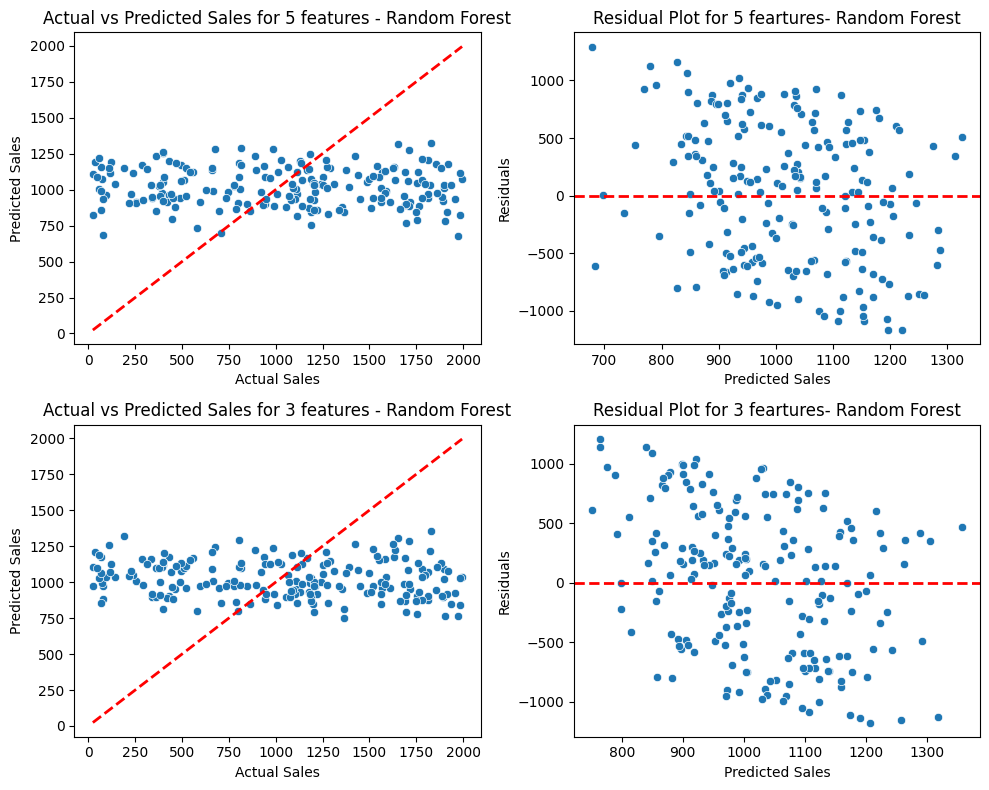

In [ ]:
# Visualization for the Random Forest for 5 features and 3 features
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.scatterplot(x=Y5_test, y=yhat_rf5)
plt.plot([Y5_test.min(), Y5_test.max()], [Y5_test.min(), Y5_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales for 5 features - Random Forest')

plt.subplot(2, 2, 2)
residuals_rf5 = Y5_test - yhat_rf5
sns.scatterplot(x=yhat_rf5, y=residuals_rf5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot for 5 feartures- Random Forest')

plt.subplot(2,2,3)
sns.scatterplot(x=Y3_test, y=yhat_rf3)
plt.plot([Y3_test.min(), Y3_test.max()], [Y3_test.min(), Y3_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales for 3 features - Random Forest')

plt.subplot(2,2,4)
residuals_rf3 = Y3_test - yhat_rf3
sns.scatterplot(x=yhat_rf3, y=residuals_rf3)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot for 3 feartures- Random Forest')

plt.tight_layout()
plt.show()

---
### 3.5. Support Vector Machine

In [ ]:
# we now try the Support Vector Machine with RandomSearch to save time and compute

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import time

svm5 = SVR()
param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'sigmoid', 'linear'],
    'gamma': ['scale', 'auto']
}

start_time = time.time()
with tqdm(total=20) as pbar:
  random_search_svm5 = RandomizedSearchCV(svm5, param_svm, n_iter=20, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
  random_search_svm5.fit(X5_train, Y5_train)
  pbar.update(1)  # Incrementing progress bar

end_time = time.time()

print(f'Runtime for SVR parameters and SVR fitting: {(end_time - start_time)/60:.2f} minutes')

start = time.time()
best_params_svm5 = random_search_svm5.best_params_
best_score_svm5 = -random_search_svm5.best_score_
end = time.time()
print(f'Runtime for finding best parameters: {(end - start)/60:.2f} minutes')
print('Best parameters for SVM-5:', best_params_svm5)
print('Best score for SVM-5:', best_score_svm5)

best_model_svm5 = random_search_svm5.best_estimator_
yhat_svm5 = best_model_svm5.predict(X5_test)

mse_svm5 = mean_squared_error(Y5_test, yhat_svm5)
r2_svm5 = r2_score(Y5_test, yhat_svm5)

print(f'Mean Squared Error for SVM 5 features: {mse_svm5}')
print(f'R² Score for SVM 5 features: {r2_svm5}')

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning:

The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.

  5%|▌         | 1/20 [02:56<55:56, 176.68s/it]

Runtime for SVR parameters and SVR fitting: 2.94 minutes
Runtime for finding best parameters: 0.00 minutes
Best parameters for SVM-5: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best score for SVM-5: 336096.06482272636
Mean Squared Error for SVM 5 features: 354157.4148627862
R² Score for SVM 5 features: -0.057687271681347685


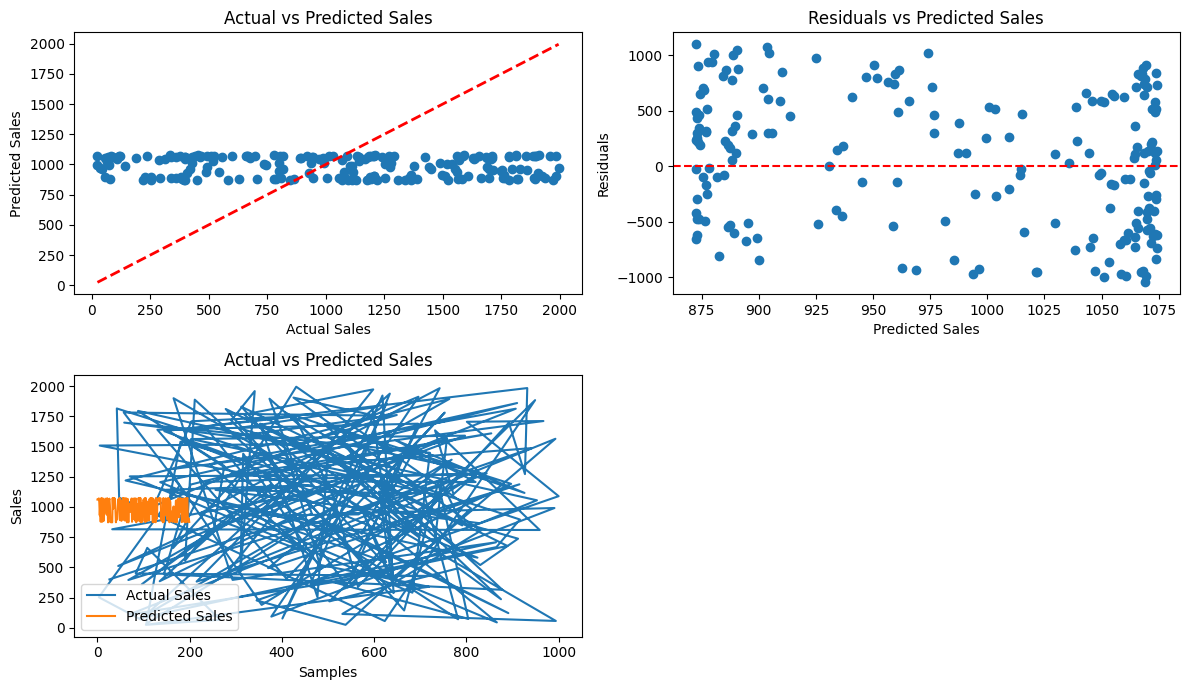

In [ ]:
# Visualizing:
plt.figure(figsize=(12, 7))

plt.subplot(2, 2, 1)
plt.scatter(Y5_test, yhat_svm5)
plt.plot([Y5_test.min(), Y5_test.max()], [Y5_test.min(), Y5_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')

plt.subplot(2, 2, 2)
residuals_svm5 = Y5_test - yhat_svm5
plt.scatter(yhat_svm5, residuals_svm5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Sales')

plt.subplot(2, 2, 3)
plt.plot(Y5_test, label='Actual Sales')
plt.plot(yhat_svm5, label='Predicted Sales')
plt.xlabel('Samples')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Now we do the same with the 3-feature set but let us time it as well:

from tqdm import tqdm

svm3= SVR()
grid_search_svm3 = GridSearchCV(svm3, param_svm, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

start_time = time.time()
for _ in tqdm(range(20)):
  grid_search_svm3.fit(X3_train, Y3_train)
end_time = time.time()

print(f'Runtime for SVR fitting: {(end_time - start_time)/60} minutes')

best_params_svm3 = grid_search_svm3.best_params_
best_score_svm3 = -grid_search_svm3.best_score_
print('Best parameters for SVM-3:', best_params_svm3)    # Output: Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
print('Best score for SVM-3:', best_score_svm3 )         # Output:

best_model_svm3 = grid_search_svm3.best_estimator_
yhat_svm3 = best_model_svm3.predict(X3_test)

mse_svm3 = mean_squared_error(Y3_test, yhat_svm3)
r2_svm3 = r2_score(Y3_test, yhat_svm3)

print(f'Mean Squared Error for SVM 5 features: {mse_svm3}')      #Output:
print(f'R² Score for SVM 5 features: {r2_svm3}')               # Output:

NameError: name 'SVR' is not defined

---
---
---
# 4. The results of the models and their performance metrics.

---
### Since the values in our dataset are assigned randomly the results you see below might seem off, however this was a good training session for practicing some machine learning algorithms, and hyperparrameter tuning.

In [ ]:
# We will create a little table that demonstrates the metrics of all the models wit their different independent variables

results = {
    'Independent_var': ['NumReviews','Price', 'Discont', '5_features_mlr', '3_features_mlr', '5_features_pr', '3_features_pr', '5_features_dt', '3_features_dt', '5_features_rf', '3_features_rf', '5_features_svm', '3_features_svm',
    'Model': ['SLR', 'SLR', 'SLR', 'MLR', 'MLR', 'PolyReg', 'PolyReg', 'DecTree', 'DecTree','RanFor', , 'RanFor']
              'SVM', 'SVM'],
    'R_Squared': [lr.score(Xr_test, yr_test), lr_p.score(Xp_test, yp_test), lr_d.score(Xd_test, yd_test),
                  lr_5.score(X5_test, Y5_test), lr_3.score(X3_test, Y3_test),
                  r2_score(Y5_test, pr5_yhat), r2_score(Y3_test, pr3_yhat),
                  best_tree.score(X5_test, Y5_test), best_tree_3.score(X3_test, Y3_test),
                  r2_rf5, r2_rf3,
                  r2_svm5, r2_svm3],
    'MSE': [mean_squared_error(yr_test, yr_hat), mean_squared_error(yp_test, yp_hat), mean_squared_error(yd_test, yd_hat),
            mean_squared_error(Y5_test, y5_pred), mean_squared_error(Y5_test, y3_pred),
            mean_squared_error(Y5_test, pr5_yhat), mean_squared_error(Y3_test, pr3_yhat),
            mean_squared_error(Y5_test, yhat), mean_squared_error(Y3_test, y3_hat),
            mse_rf5, mse_rf3,
            , mse_svm5, mse_svm3]
}

df = pd.DataFrame(results)
df
